## 5.4 Rolling window approach

The rolling window approach is an important part of the forecasting framework, as it is particularly suited to time series data. This technique is a tool used to address autocorrelation. By using a rolling window to retrain the models at specified intervals, it can capture and adapt to the evolving dynamics within each customer group’s time series. For a more detailed description of the rolling window approach see chapter 3.3.

Autocorrelation in time series data can lead to biased estimates and misleading results if not properly accounted for.

In [8]:
import os
import pandas as pd

# Define the base path
base_path = "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"

# Set the working directory (if needed, but not commonly done in Python)
os.chdir(base_path)

# Read the CSV file into a DataFrame
MSTL = pd.read_csv(os.path.join(base_path, "MSTL_decomp_results.csv"))
R_t = MSTL['Remainder']

<Figure size 1000x600 with 0 Axes>

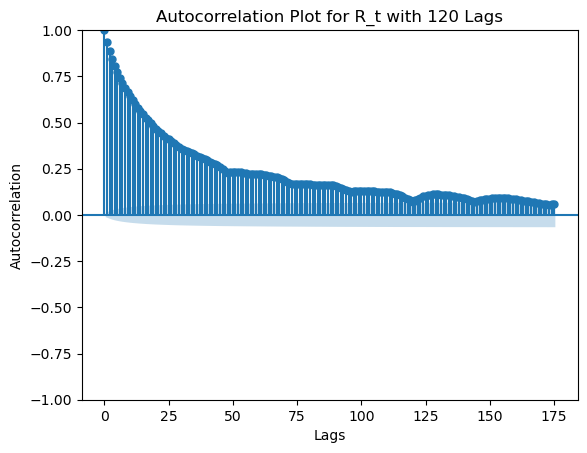

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function with 120 lags
plt.figure(figsize=(10, 6))
plot_acf(R_t, lags=175)
plt.title('Autocorrelation Plot for R_t with 120 Lags')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

As it can be seen in the plot above, there is autocorrelation in the remainders, this shows that the remainders is not just random noise, but there is actually explainable variance left from the decomposition.

The rolling window approach offers a solution by continuously retraining the model based on the most recent data. This approach ensures that the models remain sensitive to recent patterns and changes, improving the predictive accuracy and relevance.

### 5.4.1 Retraining frequency

An important decision in the rolling window approach, is determining the frequency of the model retraining. This frequency can significantly influence the forecast’s accuracy, as it balances the trade-off between model responsiveness and computational efficiency, as it can be seen demonstrated in the plot below.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
base_path = "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/OLS/Metrics/"

h1_1steps_results_path    = f"{base_path}h=1_steps_ahead=1_OLS_Metrics.csv"
h1_24steps_results_path   = f"{base_path}h=1_steps_ahead=24_OLS_Metrics.csv"
h1_48steps_results_path   = f"{base_path}h=1_steps_ahead=48_OLS_Metrics.csv"
h1_168steps_results_path  = f"{base_path}h=1_steps_ahead=168_OLS_Metrics.csv"
h1_720steps_results_path  = f"{base_path}h=1_steps_ahead=720_OLS_Metrics.csv"

h1_1steps_results    = pd.read_csv(h1_1steps_results_path)
h1_24steps_results   = pd.read_csv(h1_24steps_results_path)
h1_48steps_results   = pd.read_csv(h1_48steps_results_path)
h1_168steps_results  = pd.read_csv(h1_168steps_results_path)
h1_720steps_results  = pd.read_csv(h1_720steps_results_path)

C:\Users\madsh\AppData\Local\Temp\ipykernel_24024\4095147210.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['Steps'], rotation=45)


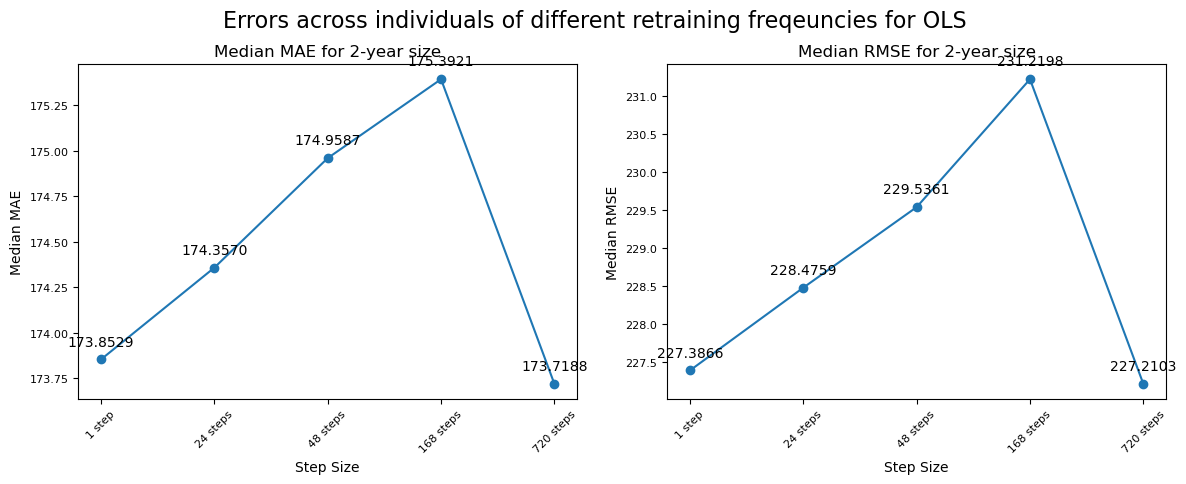

In [16]:
def plot_metric(ax, metric_name):
    # Prepare data for plotting
    median_metrics = {
        '1 step': h1_1steps_results[metric_name].median(),
        '24 steps': h1_24steps_results[metric_name].median(),
        '48 steps': h1_48steps_results[metric_name].median(),
        '168 steps': h1_168steps_results[metric_name].median(),
        '720 steps': h1_720steps_results[metric_name].median(),
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(list(median_metrics.items()), columns=['Steps', 'Median ' + metric_name])

    # Scatter and line plot
    ax.scatter(df['Steps'], df['Median ' + metric_name], color='#1f77b4')
    ax.plot(df['Steps'], df['Median ' + metric_name], color='#1f77b4')

    # Annotating each point
    for i, txt in enumerate(df['Median ' + metric_name]):
        ax.annotate(f"{txt:.4f}", (df['Steps'][i], df['Median ' + metric_name][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

    # Setting labels and title
    ax.set_title(f'Median {metric_name} for 2-year size', fontsize=12)
    ax.set_xlabel('Step Size', fontsize=10)
    ax.set_ylabel(f'Median {metric_name}', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticklabels(df['Steps'], rotation=45)

# Create a 1x2 subplot for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_metric(ax1, 'MAE')
plot_metric(ax2, 'RMSE')

# Adjust layout and add an overall title with Mathtext
plt.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('Errors across individuals of different retraining freqeuncies for OLS', fontsize=16, y=.96)

plt.show()

The effect the retraining frequency has on the forecasting accuracy is visually represented in the plot above, which displays varying metrics of forecasting accuracy against the retraining intervals, 𝑚, between each retraining of the rolling window. As illustrated, a \\( m \\) of 1, where the model is retrained at every timestep, provides lowest errors across all metrics. Proving the benefits of more frequent retraining in capturing immediate changes in the data. However, there is an observable pattern of diminishing returns when increasing frequency. For instance, while the transition from a larger \\( m \\) to \\( m=48 \\) does improve the forecast accuracy, the incremental gain in accuracy diminishes when approaching a \\( m \\) of 1. Furthermore, this intensification of training comes at the cost of computational resources, as a model with a \\( m=1 \\) takes approximately 48 times longer to fit than a model with a \\( m=48 \\). Suggesting that an optimal step size must be found that balances predictive accuracy with the practical limitations of computational expense. Especially if models that are more computationally demanding than OLS, like RF, get used since it could no longer be realistic to have a retrain frequency as low as what would be realistic with OLS.

however in this example the difference in accuracy for different retraining frequencies is very small, leading to there being close to no effect of lowering the retraining frecuency. 

### 5.4.2 Size of the static window size

In addition to the retraining frequency, another important aspect of the rolling windows approach is the length of the window, the span of historical data on which the model is trained during each iteration. This parameter is important because it defines the amount of historical data context the model has at its disposal when making predictions. A longer window length, and therefore bigger training set, can potentially capture long-term trends and seasonal patterns that remain in the remainders after the MSTL decomposition. However, it may also reduce the model’s responsiveness to the most recent shifts in the data if the time series exhibits rapid changes, as the target variable is non-stationary.

On the other hand, a shorter window length prioritizes recent data, thus making the model more reactive to new information, thereby overfitting to short-term fluctuations and losing the broader perspective provided by a more extensive data history.

Therefore, the selection of window length must be considered to ensure an optimal balance between capturing sufficient historical information and maintaining the ability to respond to new data. While also keeping in mind that a smaller training set, leaves a larger test set that the rolling window must roll over and therefore adding computational time.

In [20]:
base_path = "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/OLS/Metrics/"

h1_1steps_results_path    = f"{base_path}h=1_steps_ahead=1_OLS_Metrics.csv"
h1_24steps_results_path   = f"{base_path}h=1_steps_ahead=24_OLS_Metrics.csv"
h1_48steps_results_path   = f"{base_path}h=1_steps_ahead=48_OLS_Metrics.csv"
h1_168steps_results_path  = f"{base_path}h=1_steps_ahead=168_OLS_Metrics.csv"
h1_720steps_results_path  = f"{base_path}h=1_steps_ahead=720_OLS_Metrics.csv"

h1_2yTrain_1steps_results_path    = f"{base_path}2yTrain_h=1_steps_ahead=1_OLS_Metrics.csv"
h1_2yTrain_24steps_results_path   = f"{base_path}2yTrain_h=1_steps_ahead=24_OLS_Metrics.csv"
h1_2yTrain_48steps_results_path   = f"{base_path}2yTrain_h=1_steps_ahead=48_OLS_Metrics.csv"
h1_2yTrain_168steps_results_path  = f"{base_path}2yTrain_h=1_steps_ahead=168_OLS_Metrics.csv"
h1_2yTrain_720steps_results_path  = f"{base_path}2yTrain_h=1_steps_ahead=720_OLS_Metrics.csv"

h1_1steps_results    = pd.read_csv(h1_1steps_results_path)
h1_24steps_results   = pd.read_csv(h1_24steps_results_path)
h1_48steps_results   = pd.read_csv(h1_48steps_results_path)
h1_168steps_results  = pd.read_csv(h1_168steps_results_path)
h1_720steps_results  = pd.read_csv(h1_720steps_results_path)

h1_2yTrain_1steps_results    = pd.read_csv(h1_2yTrain_1steps_results_path)
h1_2yTrain_24steps_results   = pd.read_csv(h1_2yTrain_24steps_results_path)
h1_2yTrain_48steps_results   = pd.read_csv(h1_2yTrain_48steps_results_path)
h1_2yTrain_168steps_results  = pd.read_csv(h1_2yTrain_168steps_results_path)
h1_2yTrain_720steps_results  = pd.read_csv(h1_2yTrain_720steps_results_path)

C:\Users\madsh\AppData\Local\Temp\ipykernel_24024\4142272215.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f"{txt:.4f}", (df.index[i], df['1 year'][i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
C:\Users\madsh\AppData\Local\Temp\ipykernel_24024\4142272215.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f"{txt:.4f}", (df.index[i], df['2 years'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
C:\Users\madsh\AppData\Local\Temp\ipykernel_24024\4142272215.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

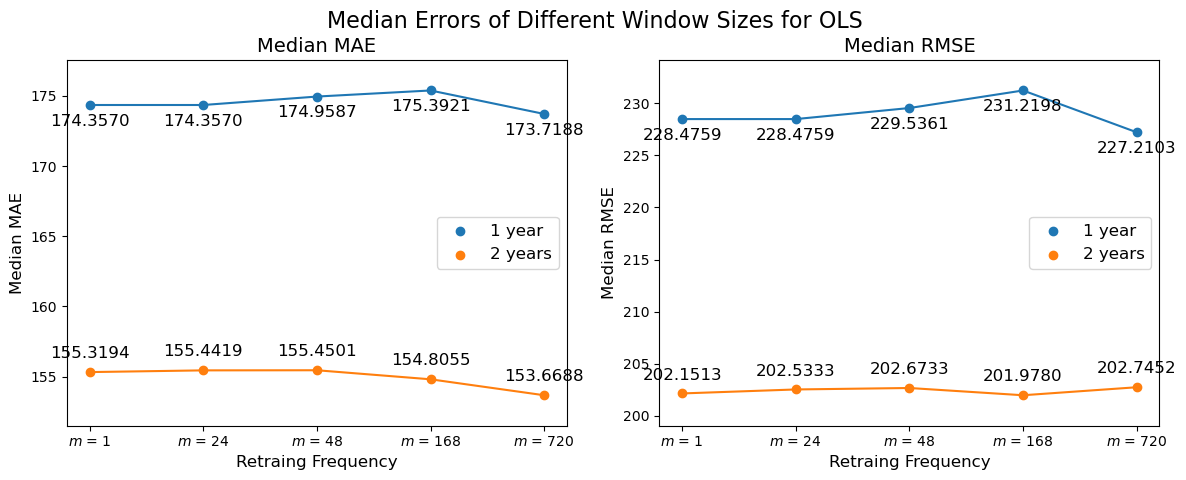

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric(ax, metric_name):
    # Use Mathtext for R^2 in the title
    display_metric_name = metric_name

    # Calculate median metric values for each file
    median_metrics = {
        '1 steps':   [h1_24steps_results[metric_name].median(), h1_2yTrain_1steps_results[metric_name].median()],
        '24 steps':  [h1_24steps_results[metric_name].median(), h1_2yTrain_24steps_results[metric_name].median()],
        '48 steps':  [h1_48steps_results[metric_name].median(), h1_2yTrain_48steps_results[metric_name].median()],
        '168 steps': [h1_168steps_results[metric_name].median(), h1_2yTrain_168steps_results[metric_name].median()],
        '720 steps': [h1_720steps_results[metric_name].median(), h1_2yTrain_720steps_results[metric_name].median()],
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(median_metrics, index=['1 year', '2 years']).T

    # Scatter and line plot for 1 year
    ax.scatter(df.index, df['1 year'], color='#1f77b4', label='1 year')
    ax.plot(df.index, df['1 year'], color='#1f77b4')

    # Scatter and line plot for 2 years
    ax.scatter(df.index, df['2 years'], color='#ff7f0e', label='2 years')
    ax.plot(df.index, df['2 years'], color='#ff7f0e')

    # Annotating each point
    for i, txt in enumerate(df['1 year']):
        ax.annotate(f"{txt:.4f}", (df.index[i], df['1 year'][i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
    for i, txt in enumerate(df['2 years']):
        ax.annotate(f"{txt:.4f}", (df.index[i], df['2 years'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Setting labels and title with Mathtext
    ax.set_title(f'Median {display_metric_name}', fontsize=14)
    ax.set_xlabel('Retraing Frequency', fontsize=12)
    ax.set_ylabel(f'Median {display_metric_name}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Custom x-axis labels using LaTeX
    custom_labels = [f"$m$ = {label.split()[0]}" for label in df.index]
    ax.set_xticks(range(len(custom_labels)))  # Ensure x-ticks are correctly positioned
    ax.set_xticklabels(custom_labels)  # Set custom xtick labels with rotation

    # Adjusting y-axis limits
    min_val = df.min().min()
    max_val = df.max().max()
    buffer = (max_val - min_val) * 0.1  # Adding 10% buffer at the top and bottom
    ax.set_ylim(min_val - buffer, max_val + buffer)

    # Adding a legend
    ax.legend(fontsize=12)

# Create a 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_metric(ax1, 'MAE')
plot_metric(ax2, 'RMSE')

# Adjust layout and add an overall title with Mathtext
plt.tight_layout()
fig.subplots_adjust(top=0.85)  # Adjust the top space to accommodate the title
fig.suptitle('Median Errors of Different Window Sizes for OLS', fontsize=16, y=.95)

plt.show()


the plot above shows that the rolling window’s window length, especially the choice between one or two years of training data, shows a clear influence on the OLS model’s forecasting performance. The plot shows the median *MAE* and *RMSE* for different retraining frequencies when models are trained on one-year versus two-year training data sets.

For the two-year training window, the model maintains a consistently lower median MAE at all retraining frequencies. It is clear. This trend suggest that a longer training window enables the model to track and adapt to more data patterns effectively, which can be crucial in making accurate predictions.

Given the consistency in error MAE and RMSE values for the two-year training window at higher retraining frequencies, this leads to the conclusion that a two-year training window is preferable.

### 5.4.3 Size of the static window size effect on Random Forest

When comparing the influence of training set size on forecasting models, it’s important to recognize that RF and OLS regression models have fundamentally different approaches to learning from historical data, which affects how they utilize and benefit from the size of the training set.

For an OLS model, the training set size directly affects the parameter estimation. A larger training set can provide a more accurate estimation of the model’s coefficients by capturing more variability and potential patterns in the data. However, it may also incorporate more noise and older data points that could be less relevant in a timeseries, even after it has been decomposed, potentially making the model less responsive to recent trends.

In contrast, RF, a non-parametric, ensemble learning method, is less about estimating specific parameters and more about building a variety of decision trees to create a robust predictive model. Each tree in a RF model is constructed from a subset of the data and features, which means a larger training set can provide a richer set of sub-samples. This can lead to a more diverse and comprehensive ensemble, potentially capturing complex nonlinear relationships that a linear model like OLS may miss. However, RF models can also become more complex and computationally intensive with larger datasets, as more trees may be required to maintain model accuracy.

The additional data in a larger training set could allow RF models to build trees that are less prone to overfitting, given their ability to leverage deeper interactions within the data. This depth of interaction is something OLS models, whit their reliance on linear relationships, cannot exploit as effectively. Consequently, the same training set size that is optimal for an OLS model may not be optimal for a RF model. While a one-year window might provide the best balance for an OLS model between capturing trends and remaining responsive to recent changes, a RF model could potentially benefit from a two-year window if the additional data helps in capturing more complex patterns without overfitting.

Therefore, when choosing the training set size for a RF model, it is a must to consider its unique ability to extract and learn from complex data structures. This means that while a one-year training window may be adequate, for an OLS model, it cannot be assumed that a RF model will necessarily operate with the same efficiency or predictive stability using the same training set size. Each model’s design must be considered to determine the most suitable training window.

# SPACE FOR PLOTS

# SPACE FOR PLOTS

# SPACE FOR PLOTS

The comparison of the RF models with 1 and 2 year training window sizes, as illustrated in Figures 26 and 27, shows similar observations as those for OLS regarding the effectiveness of the training window size, 𝑛𝑡𝑟𝑎𝑖𝑛. Both from the median and the full distribution of the evaluation metrics, it is demonstrated that the RF model shows improved accuracy with a one-year training window size, similar to the OLS model. This pattern is evident from the consistently lower median MAE and RMSE for the one-year training window across various retraining frequencies. The distribution of MAE and RMSE further supports this, showing a more concentrated range of errors with fewer outliers, suggesting a more stable model. Therefore, based on the empirical evidence presented in sections 5.4.2 and 5.4.3, 
one-year static window size will be used for both the RF and OLS models to maximize predictive accuracy and model responsiveness to recent data trends.